In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import numpy as np 
import pandas as pd 
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from collections import Counter
import pandas_profiling as pp

In [2]:
df = pd.read_csv('heart_2020_cleaned.csv')

In [3]:
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166531 entries, 0 to 166530
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      166531 non-null  object 
 1   BMI               166531 non-null  float64
 2   Smoking           166531 non-null  object 
 3   AlcoholDrinking   166531 non-null  object 
 4   Stroke            166531 non-null  object 
 5   PhysicalHealth    166531 non-null  float64
 6   MentalHealth      166531 non-null  float64
 7   DiffWalking       166531 non-null  object 
 8   Sex               166531 non-null  object 
 9   AgeCategory       166531 non-null  object 
 10  Race              166531 non-null  object 
 11  Diabetic          166531 non-null  object 
 12  PhysicalActivity  166531 non-null  object 
 13  GenHealth         166530 non-null  object 
 14  SleepTime         166530 non-null  float64
 15  Asthma            166530 non-null  object 
 16  KidneyDisease     16

In [5]:
df.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,166531.000000,166531.000000,166531.000000,166530.000000
mean,28.310366,3.381527,3.913878,7.108653
std,6.380668,7.954469,7.953044,1.453468
min,12.020000,0.000000,0.000000,1.000000
25%,23.920000,0.000000,0.000000,6.000000
50%,27.320000,0.000000,0.000000,7.000000
75%,31.450000,2.000000,3.000000,8.000000
max,94.850000,30.000000,30.000000,24.000000


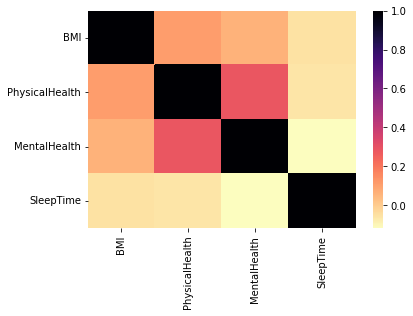

In [6]:
sns.heatmap(df.corr(),cmap='magma_r')

we can see some correlation between physical and mental health

In [7]:
for i in df.columns:
  if df[i][0] == 'Yes' or df[i][0] == 'No':
    df[i] = df[i].map({'Yes': 1, 'No': 0})


In [8]:
df

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,Female,55-59,White,1.0,1,Very good,5.0,1.0,0.0,1.0
1,0,20.34,0,0,1,0.0,0.0,0,Female,80 or older,White,0.0,1,Very good,7.0,0.0,0.0,0.0
2,0,26.58,1,0,0,20.0,30.0,0,Male,65-69,White,1.0,1,Fair,8.0,1.0,0.0,0.0
3,0,24.21,0,0,0,0.0,0.0,0,Female,75-79,White,0.0,0,Good,6.0,0.0,0.0,1.0
4,0,23.71,0,0,0,28.0,0.0,1,Female,40-44,White,0.0,1,Very good,8.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166526,0,32.01,0,0,0,15.0,0.0,1,Female,70-74,White,0.0,1,Good,6.0,0.0,0.0,0.0
166527,0,35.95,0,0,0,0.0,0.0,0,Male,25-29,White,0.0,0,Good,9.0,0.0,0.0,0.0
166528,0,19.20,1,0,0,7.0,10.0,0,Female,18-24,White,0.0,1,Good,6.0,0.0,0.0,0.0
166529,0,25.11,0,0,0,0.0,0.0,0,Male,55-59,White,0.0,1,Excellent,7.0,0.0,0.0,0.0


In [9]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2,
random_state=42)

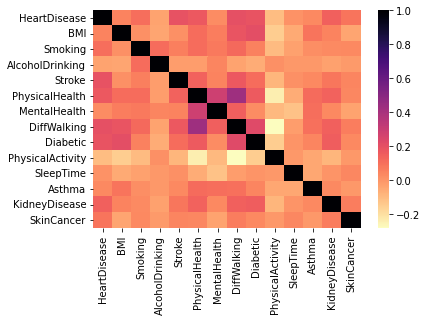

In [10]:
sns.heatmap(df.corr(),cmap='magma_r')

from the yes/no columns we can take out some more inferences
diffwalking and physical health have high correlation

heart disease seems to be correlated to stroke, diffwalking, diabetes, physical health 

In [11]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
dff = ordinal_encoder.fit_transform(df)
dff

array([[0.000e+00, 1.670e+02, 1.000e+00, ..., 1.000e+00, 0.000e+00,
        1.000e+00],
       [0.000e+00, 4.480e+02, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 9.820e+02, 1.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [0.000e+00, 3.580e+02, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 8.550e+02, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 1.949e+03, 1.000e+00, ...,       nan,       nan,
              nan]])

In [12]:
df.isnull().sum()

HeartDisease           0
BMI                    0
Smoking                0
AlcoholDrinking        0
Stroke                 0
PhysicalHealth         0
MentalHealth           0
DiffWalking            0
Sex                    0
AgeCategory            0
Race                   0
Diabetic            5121
PhysicalActivity       0
GenHealth              1
SleepTime              1
Asthma                 1
KidneyDisease          1
SkinCancer             1
dtype: int64

drop the rows where diabetes is null 

In [13]:
df = df.dropna()
df.isnull().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MaxAbsScaler 

x = df.drop(['HeartDisease'], axis = 1)
y = df['HeartDisease']

cat_encoder = OneHotEncoder()
x = cat_encoder.fit_transform(x)

scaling = MaxAbsScaler().fit(x)
x = scaling.transform(x)

x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [15]:
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix

In [16]:
accuracy_list = []

In [17]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
log_reg_pred = log_reg.predict(x_test)
log_reg_acc = accuracy_score(y_test, log_reg_pred)
accuracy_list.append(100*log_reg_acc)

In [18]:
print("Accuracy of Logistic Regression is : ", "{:.2f}%".format(100* log_reg_acc))

Accuracy of Logistic Regression is :  91.45%


<Figure size 432x288 with 0 Axes>

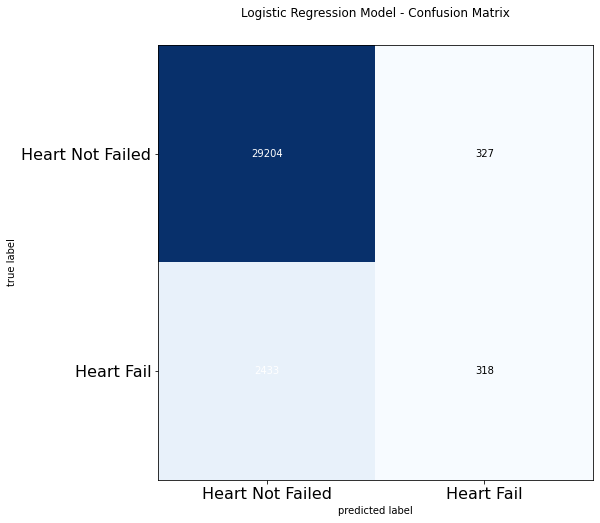

In [19]:
cm = confusion_matrix(y_test, log_reg_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Logistic Regression Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [ ]:
sv_clf = SVC()
sv_clf.fit(x_train, y_train)
sv_clf_pred = sv_clf.predict(x_test)
sv_clf_acc = accuracy_score(y_test, sv_clf_pred)
accuracy_list.append(100* sv_clf_acc)

In [ ]:
print("Accuracy of SVC is : ", "{:.2f}%".format(100* sv_clf_acc))

In [ ]:
cm = confusion_matrix(y_test, sv_clf_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("SVC Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [ ]:
kn_clf = KNeighborsClassifier(n_neighbors=6)
kn_clf.fit(x_train, y_train)
kn_pred = kn_clf.predict(x_test)
kn_acc = accuracy_score(y_test, kn_pred)
accuracy_list.append(100*kn_acc)

In [ ]:
print("Accuracy of K Neighbors Classifier is : ", "{:.2f}%".format(100* kn_acc))

In [ ]:
cm = confusion_matrix(y_test, kn_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("K Neighbors Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [ ]:
dt_clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0, criterion='entropy')
dt_clf.fit(x_train, y_train)
dt_pred = dt_clf.predict(x_test)
dt_acc = accuracy_score(y_test, dt_pred)
accuracy_list.append(100*dt_acc)

In [ ]:
print("Accuracy of Decision Tree Classifier is : ", "{:.2f}%".format(100* dt_acc))

In [ ]:
cm = confusion_matrix(y_test, dt_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Decision Tree Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [20]:
r_clf = RandomForestClassifier(max_features=0.5, max_depth=15, random_state=1)
r_clf.fit(x_train, y_train)
r_pred = r_clf.predict(x_test)
r_acc = accuracy_score(y_test, r_pred)
accuracy_list.append(100*r_acc)

In [21]:
print("Accuracy of Random Forest Classifier is : ", "{:.2f}%".format(100* r_acc))

Accuracy of Random Forest Classifier is :  91.51%


<Figure size 432x288 with 0 Axes>

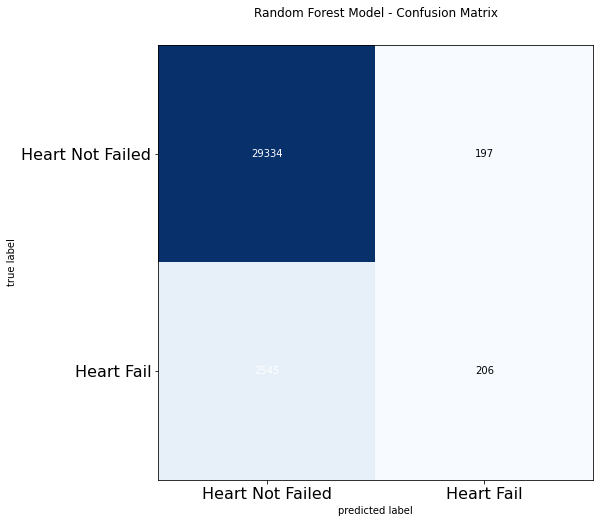

In [22]:
cm = confusion_matrix(y_test, r_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Random Forest Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [ ]:
gradientboost_clf = GradientBoostingClassifier(max_depth=2, random_state=1)
gradientboost_clf.fit(x_train,y_train)
gradientboost_pred = gradientboost_clf.predict(x_test)
gradientboost_acc = accuracy_score(y_test, gradientboost_pred)
accuracy_list.append(100*gradientboost_acc)

In [ ]:
print("Accuracy of Gradient Boosting is : ", "{:.2f}%".format(100* gradientboost_acc))

In [ ]:
cm = confusion_matrix(y_test, gradientboost_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Gredient Boosting Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [23]:
import xgboost

In [24]:
xgb_clf = xgboost.XGBRFClassifier(max_depth=3, random_state=1)
xgb_clf.fit(x_train,y_train)
xgb_pred = xgb_clf.predict(x_test)
xgb_acc = accuracy_score(y_test, xgb_pred)
accuracy_list.append(100*xgb_acc)

In [25]:
print("Accuracy of XGBRFClassifier is : ", "{:.2f}%".format(100* xgb_acc))

Accuracy of XGBRFClassifier is :  91.54%


<Figure size 432x288 with 0 Axes>

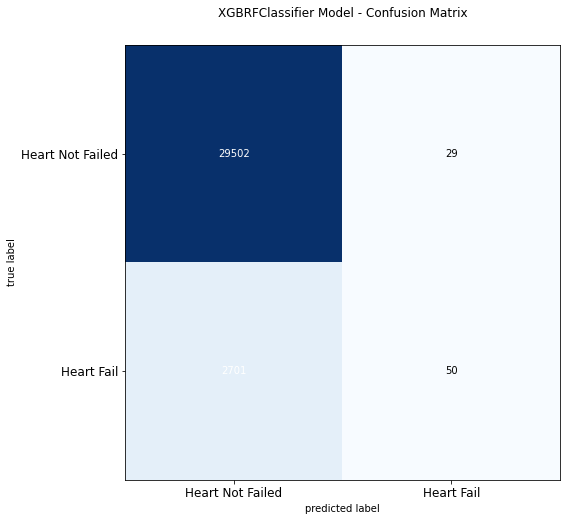

In [26]:
cm = confusion_matrix(y_test, xgb_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("XGBRFClassifier Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=12)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=12)
plt.show()